In [48]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [49]:
df = pd.read_csv('../../../data_set/train-data.csv', index_col=0)

Prima di tutto osserviamo la panoramica generale del dataset

In [50]:
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


Già notiamo la mancanza di uniformità nelle unità di misura della feature Mileage, probabilmente dovuta al carburante differente. Per comprendere a pieno la natura delle features:

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 658.3+ KB


Quello che risalta subito all'occhio sono i missing values (NaN) in più di qualche features, dovremmo tenerne conto  

**Dizionario dei dati**  
Name: marchio + modello. E' qualitativa, e si potrebbe estrarre la marca.  
Location: altra variabile categorica, che descrive la città o la regione in cui l'auto è in vendita.   
Year: l'anno di produzione del modello. Numerica, discreta, scala a intervalli. Si potrebbe derivare l'età dell'auto.  
Kilometers_Driven: i chilometri totali percorsi dall'auto. Numerica, continua, scala ratio. Unità di misura: km.    
Fuel_type: tipo carburante. Categorica.  
Transmission: categorica binaria. Descrizione: automatica o manuale.  
Owner_Type: categorica ed ordinale perché "Firsthand" ha un valore maggiore.   
Mileage: indica il consumo di carburante, è numerica e continua, scala ratio, anche se in realtà non può consumare 0. Unità di misura: kmpl, km/kg.  
Engine: cilindrata del motore. E' numerica e continua, scala ratio. Unità di misura: cc.   
Power: la potenza massima del motore in bhp, è numerica e continua, scala ratio. Unità di misura: bhp.  
Seats: numero di posti a sedere, è numerica e discreta, ratio. Potrebbe definire la categoria del veicolo (SUV, monovolume ecc...)  
New_Price: il prezzo dell'auto nuova dello stesso modello. Numerica, continua, ratio. Valuta: INR Lakhs.  
Price: variabile target, è il prezzo di vendita dell'auto usata. Numerica, continua, ratio. Essendo una variabile continua, il problema da risolvere è un problema di regressione. Valuta: INR Lakhs.  

**Definizione degli obiettivi dell’analisi dei dati**  
Quali sono i fattori principali che determinano il prezzo (Price) di un'auto usata?  
In che modo l'età dell'auto (derivata da Year) e i chilometri percorsi (Kilometers_Driven) interagiscono nel definire il valore?  
Quale impatto hanno le caratteristiche tecniche come il tipo di carburante (Fuel_Type) e la Transmission sul prezzo?    
Esistono marche (estratte da Name) o località (Location) specifiche in cui le auto mantengono meglio il loro valore?  


**Pulizia e Preprocessing**  
Iniziamo capendo con quanti NaN abbiamo a che fare, e come gestirli.

In [52]:
df.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

In [53]:
for x in df:
    if df[x].isnull().sum() > 0:
        print(f"Percentuale di NaN in {x}: ", (df[x].isnull().sum()/df[x].size)*100, "%")


Percentuale di NaN in Mileage:  0.033228110981890685 %
Percentuale di NaN in Engine:  0.5981059976740323 %
Percentuale di NaN in Power:  0.5981059976740323 %
Percentuale di NaN in Seats:  0.6977903306197043 %
Percentuale di NaN in New_Price:  86.31001827546105 %


Prima di potere gestire questi valori mancanti dobbiamo sistemare un po' di cose. Intanto rimuoviamo le unità di misura e trasformiamo alcune colonne in numeriche.

La gestione della colonna Mileage è particolare, in quanto abbiamo due unità di misura differenti a seconda del carburante, naturalmente dobbiamo uniformare ad una sola unità di misura. Intanto controlliamo tutte le possibili unità di misura:

In [54]:
mileage_units = df['Mileage'].str.split().str[-1]
mileage_units.unique()

array(['km/kg', 'kmpl', nan], dtype=object)

---

Inizio modifica di ciccio

Questo accade perché tipicamente, per calcolare la quantità carburante consumato al chilometro, si utilizzano propreità diverse in base al tipo carburante dell'auto.

In genere:
- kmpl - chilometri al litro, usato per carburanti liquidi (benzina, diesel, GPL)
- km/kg - chilometri al chilogrammo, usato per carburanti diversi (CNG)

Vorremmo quindi, rimuovere o riempire i valori mancanti e sopratutto standardizzare le differenti unità di misura, in modo da averne solamente una.

Importante: ogni tipo di carburante ha una differente formula di conversione.

| Fuel     | Potere calorifico | Conversione (L → kg) approssimativa       |
| -------- | ----------------- | ----------------------------------------- |
| Petrol   | 32 MJ/l           | 1 L ≈ 0.74 kg (32/43 MJ/kg)               |
| Diesel   | 36 MJ/l           | 1 L ≈ 0.85 kg (36/42 MJ/kg)               |
| LPG      | 25 MJ/l           | 1 L ≈ ??? non serve, già espresso in km/kg |
| CNG      | 50 MJ/kg          | 1 L ≈ ??? non serve, già espresso in km/kg |
| Electric | -                 | non convertibile                          |

In [55]:
df_clean2 = df.copy()

df_clean2['Mileage_Unit'] = df_clean2['Mileage'].str.split(' ').str[1]

expected_units = {
    'Petrol': 'kmpl',
    'Diesel': 'kmpl',
    'LPG': 'km/kg',
    'CNG': 'km/kg',
    'Electric': None
}

def check_consistency(row):
    expected = expected_units[row['Fuel_Type']]
    actual = row['Mileage_Unit']
    
    if row['Fuel_Type'] == 'Electric':
        return pd.isna(actual)
    
    return actual == expected

df_clean2['Mileage_Consistent'] = df_clean2.apply(check_consistency, axis=1)

consistency_report = (
    df_clean2
    .groupby('Fuel_Type')['Mileage_Consistent']
    .value_counts()
    .unstack(fill_value=0)
)

print(consistency_report)


Mileage_Consistent  True
Fuel_Type               
CNG                   56
Diesel              3205
Electric               2
LPG                   10
Petrol              2746


In [56]:
# Fattori di conversione da km/l a km/kg
conversion_factors = {
    'Petrol': 1/0.74,   # kmpl → km/kg
    'Diesel': 1/0.85,   # kmpl → km/kg
    'LPG': None,        # già km/kg
    'CNG': None,        # già km/kg
    'Electric': None    # ← RESTA NaN
}

def convert_to_kmpkg(row):
    fuel = row['Fuel_Type']
    value = row['Mileage_Value']
    unit = row['Mileage_Unit']
    
    # Valore mancante
    if pd.isna(value):
        return np.nan
    
    # Electric → lasciamo NaN
    if fuel == 'Electric':
        return np.nan
    
    # Se è già in km/kg → lascia così
    if unit == 'km/kg':
        return value
    
    # Se è in kmpl → converti
    factor = conversion_factors[fuel]
    if unit == 'kmpl' and factor is not None:
        return value / factor
    
    return np.nan

# Estrazione numeri e unità in colonne separate
df['Mileage_Value'] = df['Mileage'].str.split(' ').str[0]
df['Mileage_Value'] = pd.to_numeric(df['Mileage_Value'], errors='coerce')

df['Mileage_Unit'] = df['Mileage'].str.split(' ').str[1]

# Applico la conversione
df['Mileage_kmpkg'] = df.apply(convert_to_kmpkg, axis=1)

median_value = df['Mileage_kmpkg'].median()
df['Mileage_kmpkg'] = df['Mileage_kmpkg'].fillna(median_value)

# Rendo Mileage definitivo
df['Mileage'] = df['Mileage_kmpkg']

df.drop(columns=['Mileage_kmpkg', 'Mileage_Value', 'Mileage_Unit'], inplace=True)

df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6000,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,16.7195,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,13.4680,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,17.6545,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,12.9200,1968 CC,140.8 bhp,5.0,NaN,17.74


Fine modifica di ciccio

---

In [57]:
df['Power'] = df['Power'].str.split(' ').str[0]
df['Power'] = pd.to_numeric(df['Power'], errors='coerce')

In [58]:
df['New_Price'] = df['New_Price'].str.split(' ').str[0]
df['New_Price'] = pd.to_numeric(df['New_Price'], errors='coerce')

In [59]:
df['Engine'] = df['Engine'].str.split(' ').str[0]
df['Engine'] = pd.to_numeric(df['Engine'], errors='coerce')

In [60]:
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6000,998.0,58.16,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,16.7195,1582.0,126.20,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,13.4680,1199.0,88.70,5.0,8.61,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,17.6545,1248.0,88.76,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,12.9200,1968.0,140.80,5.0,NaN,17.74


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6019 non-null   float64
 8   Engine             5983 non-null   float64
 9   Power              5876 non-null   float64
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    float64
 12  Price              6019 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 658.3+ KB


Ora controlliamo i valori di ogni singola colonna, per capire se fanno parte del dominio. Ad esempio non può esserci un auto con 0 posti.

In [62]:
print(df["Location"].unique())

['Mumbai' 'Pune' 'Chennai' 'Coimbatore' 'Hyderabad' 'Jaipur' 'Kochi'
 'Kolkata' 'Delhi' 'Bangalore' 'Ahmedabad']


In [63]:
unique_values = df['Year'].unique()
bad_values = unique_values[(unique_values <= 0) | (unique_values >= 2025)]
print(bad_values)

[]


In [64]:
unique_values = df['Kilometers_Driven'].unique()
bad_values = unique_values[(unique_values <= 0)]
print(bad_values)

[]


In [65]:
print(df["Fuel_Type"].unique())

['CNG' 'Diesel' 'Petrol' 'LPG' 'Electric']


In [66]:
print(df["Transmission"].unique())

['Manual' 'Automatic']


In [67]:
print(df["Owner_Type"].unique())

['First' 'Second' 'Fourth & Above' 'Third']


In [68]:
unique_values = df['Mileage'].unique()
bad_values = unique_values[(unique_values <= 0)]
print(bad_values)

[0.]


In [69]:
bad_values = df.loc[df['Mileage'] <= 0, 'Mileage']
print(bad_values.value_counts())

Mileage
0.0    68
Name: count, dtype: int64


In [70]:
print(df['Engine'].unique())

[ 998. 1582. 1199. 1248. 1968.  814. 1461. 2755. 1598. 1462. 1497. 2179.
 2477. 1498. 2143. 1995. 1984. 1197. 2494. 1798. 2696. 2698. 1061. 1198.
 2987.  796.  624. 1999. 1991. 2694. 1120. 2498.  799. 2393. 1399. 1796.
 2148. 1396. 1950. 4806. 1998. 1086. 1193. 2982. 1493. 2967. 2993. 1196.
 1799. 2497. 2354. 1373. 2996. 1591. 2894. 5461. 1595.  936. 1997.   nan
 1896. 1390. 1364. 2199.  993.  999. 1405. 2956. 1794.  995. 2496. 1599.
 2400. 1495. 2523.  793. 4134. 1596. 1395. 2953. 1586. 2362. 1496. 1368.
 1298. 1956. 1299. 3498. 2835. 1150. 3198. 1343. 1499. 1186. 1590. 2609.
 2499. 2446. 1978. 2360. 3436. 2198. 4367. 2706. 1422. 2979. 1969. 1489.
 2489. 1242. 1388. 1172. 2495. 1194. 3200. 1781. 1341. 2773. 3597. 1985.
 2147. 1047. 2999. 2995. 2997. 1948. 2359. 4395. 2349. 2720. 1468. 3197.
 2487. 1597. 2771.   72. 4951.  970. 2925. 2200. 5000. 2149. 5998. 2092.
 5204. 2112. 1797.]


In [71]:
unique_values = df['Power'].unique()
bad_values = unique_values[(unique_values <= 0)]
print(bad_values)

[]


In [72]:
bad_values = df.loc[df['Seats'] <= 0, 'Seats']
print(bad_values.value_counts())

Seats
0.0    1
Name: count, dtype: int64


In [73]:
bad_values = df.loc[df['New_Price'] <= 0, 'New_Price']
print(bad_values.value_counts())

Series([], Name: count, dtype: int64)


In [74]:
bad_values = df.loc[df['Price'] <= 0, 'Price']
print(bad_values.value_counts())

Series([], Name: count, dtype: int64)


Notiamo che è tutto corretto tranne un elemento in Seats e 68 in Mileage. Potremmo semplicemente considerarli come dei NaN e gestirli come tali.

Ora possiamo gestire i NaN, abbiamo intenzione di imputare con la mediana, perché essendo un dataset con prezzi d'auto, potrebbe essere asimmetrica la distribuzione, quindi vogliamo optare per una scelta più robusta e sicura. (Mileage aspettare conversione di unità). Infine abbiamo deciso di droppare la colonna New_Price, in quanto ben l'86% dei dati è un valore NaN, e provare ad imputare creerebbe solo che rumore.

Percentuale di NaN in Mileage:  0.033228110981890685 %
Percentuale di NaN in Engine:  0.5981059976740323 %
Percentuale di NaN in Power:  0.5981059976740323 % 
Percentuale di NaN in Seats:  0.6977903306197043 % (0)
Percentuale di NaN in New_Price:  86.31001827546105 %



In [75]:
df = df.drop('New_Price', axis=1)

In [76]:
cols_to_impute = ['Power', 'Mileage', 'Engine', 'Seats']
df[cols_to_impute] = df[cols_to_impute].replace(0.0, np.nan)

for col in cols_to_impute:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

In [77]:
df['Engine'] = df['Engine'].astype('int64');
df['Seats'] = df['Seats'].astype('int64');

Abbiamo corretto gli ultimi Dtype.

La colonna name vorremmo fosse più rappresentativa, per questo motivo vorremo modificarle in due colonne una "Brand", e una "Model".

In [78]:
df['Brand'] = df['Name'].str.split(' ').str[0]
df['Model'] = df['Name'].str.split(' ').str[1]
df = df.drop('Name', axis=1)

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           6019 non-null   object 
 1   Year               6019 non-null   int64  
 2   Kilometers_Driven  6019 non-null   int64  
 3   Fuel_Type          6019 non-null   object 
 4   Transmission       6019 non-null   object 
 5   Owner_Type         6019 non-null   object 
 6   Mileage            6019 non-null   float64
 7   Engine             6019 non-null   int64  
 8   Power              6019 non-null   float64
 9   Seats              6019 non-null   int64  
 10  Price              6019 non-null   float64
 11  Brand              6019 non-null   object 
 12  Model              6019 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 658.3+ KB


In [80]:
first_cols = ['Brand', 'Model']

remaining_cols = [col for col in df.columns if col not in first_cols]

df = df[first_cols + remaining_cols]
df.head()
df.head()

,Brand,Model,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti,Wagon,Mumbai,2010,72000,CNG,Manual,First,26.6000,998,58.16,5,1.75
1,Hyundai,Creta,Pune,2015,41000,Diesel,Manual,First,16.7195,1582,126.20,5,12.50
2,Honda,Jazz,Chennai,2011,46000,Petrol,Manual,First,13.4680,1199,88.70,5,4.50
3,Maruti,Ertiga,Chennai,2012,87000,Diesel,Manual,First,17.6545,1248,88.76,7,6.00
4,Audi,A4,Coimbatore,2013,40670,Diesel,Automatic,Second,12.9200,1968,140.80,5,17.74


Verifichiamo che non ci siano errori di battitura o altro

In [81]:
df['Brand'].value_counts()

Brand
Maruti           1211
Hyundai          1107
Honda             608
Toyota            411
Mercedes-Benz     318
Volkswagen        315
Ford              300
Mahindra          272
BMW               267
Audi              236
Tata              186
Skoda             173
Renault           145
Chevrolet         121
Nissan             91
Land               60
Jaguar             40
Fiat               28
Mitsubishi         27
Mini               26
Volvo              21
Porsche            18
Jeep               15
Datsun             13
Force               3
ISUZU               2
Smart               1
Isuzu               1
Ambassador          1
Bentley             1
Lamborghini         1
Name: count, dtype: int64

In [82]:
df['Model'].unique()

array(['Wagon', 'Creta', 'Jazz', 'Ertiga', 'A4', 'EON', 'Micra', 'Innova',
       'Vento', 'Indica', 'Ciaz', 'City', 'Swift', 'Rover', 'Pajero',
       'Amaze', 'Duster', 'New', '3', 'S', 'A6', 'i20', 'Alto', 'WRV',
       'Corolla', 'Ssangyong', 'Vitara', 'KUV', 'M-Class', 'Polo', 'Nano',
       'Elantra', 'Xcent', 'Thar', 'Grand', 'KWID', 'i10', 'X-Trail',
       'Zen', 'Figo', 'C-Class', 'Cayenne', 'XUV500', 'Terrano', 'Brio',
       'Fiesta', 'Santro', 'Zest', 'Ritz', '5', 'Fortuner', 'Ecosport',
       'Verna', 'GO', 'Omni', 'Etios', 'XF', 'Eeco', 'Civic', 'V40', 'B',
       'Scorpio', 'CR-V', 'SLC', '1', 'Beat', 'Rapid', 'RS5', 'Superb',
       'X5', 'GLC', 'Countryman', 'Optra', 'Lodgy', 'E-Class', 'Baleno',
       'Laura', 'NuvoSport', 'Fabia', 'Indigo', 'Q3', 'Octavia', 'A8',
       'Verito', 'Cooper', 'Santa', 'X1', 'Accent', 'Tucson', 'GLE',
       'A-Star', 'Grande', 'X3', 'EcoSport', 'Q7', 'Jetta', 'GLA',
       'Celerio', 'Sumo', 'Accord', '6', 'Manza', 'Spark', 'Clubman'

Perfetto. Ora rimuoviamo eventuali righe duplicate

In [83]:
duplicate_count = df.duplicated().sum()

print(f"Ci sono {duplicate_count} righe duplicate.")

Ci sono 2 righe duplicate.


In [84]:
df.drop_duplicates(inplace=True)

Adesso passiamo alla gestione degli outliers. Prima di tutto, indentifichiamoli con gli appositi boxplot.

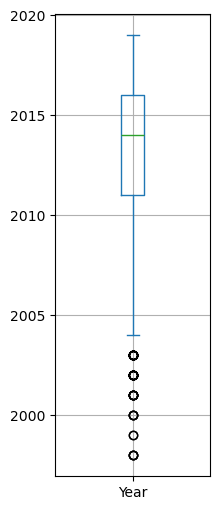

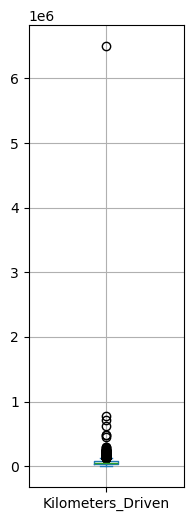

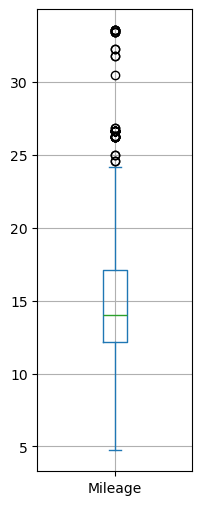

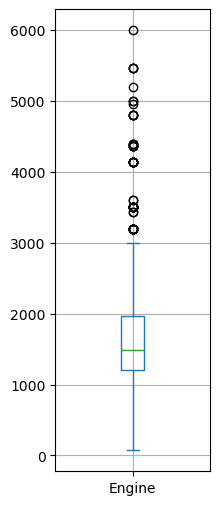

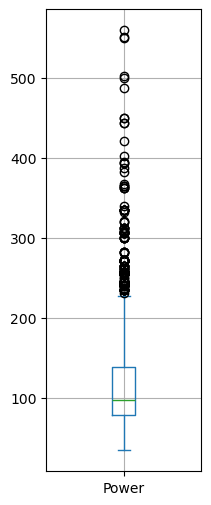

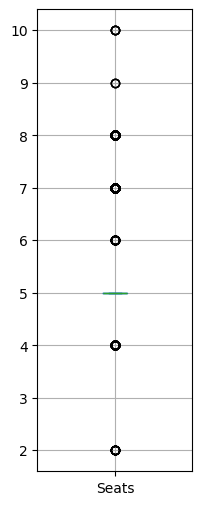

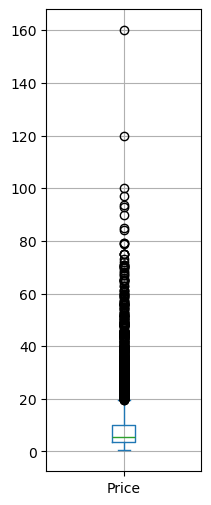

In [85]:
for x in ['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Price']:
    df[x].plot.box(figsize=(2,6))
    plt.grid()
    plt.show()

Procediamo per ordine. Intanto notiamo che in Year non sembrerebbero molti gli outlier, quindi potremmo pure rimuoverli, questo poiché auto molto vecchie seguono normative differente, un mercato differente, il che potrebbe portare solo che confusione. Verifichiamo quanti sono:

In [86]:
threshold = 2005
auto_vecchie = df[df['Year'] < threshold]

print(f"Numero di auto prima del {threshold}: {len(auto_vecchie)}")
print(auto_vecchie[['Year', 'Brand', 'Price']].head())

Numero di auto prima del 2005: 81
     Year   Brand  Price
222  2004  Maruti   1.25
274  2002  Maruti   0.55
315  2000    Tata   1.50
336  2004  Toyota   2.50
364  2003  Maruti   0.65


Sono veramente poche, possiamo pure rimuoverle. Inoltre, guardando i prezzi (0.55 Lakh, 1.25 Lakh), queste auto appartengono a un mercato "di fine vita" che segue logiche molto diverse dal resto del dataset. Mantenerle rischierebbe solo di aggiungere rumore per i casi limite.

In [87]:
df = df[df['Year'] >= 2005]
df.reset_index(drop=True, inplace=True)

Ora passiamo a Kilometers, si nota subito quel numero spaventoso lì in alto, sicuramente impossibile. Sicuramente un errore. Meglio rimuoverlo. 

In [88]:
print("Outlier estremi (> 1 milione km):")
print(df[df['Kilometers_Driven'] > 1000000])

df = df[df['Kilometers_Driven'] < 1000000]
df.reset_index(drop=True, inplace=True)

Outlier estremi (> 1 milione km):
     Brand Model Location  Year  Kilometers_Driven Fuel_Type Transmission  \
2300   BMW    X5  Chennai  2017            6500000    Diesel    Automatic   

     Owner_Type  Mileage  Engine  Power  Seats  Price  
2300      First  13.5745    2993  258.0      5   65.0  


Ora vogliamo ristampare il boxplot, poiché era poco comprensibile.

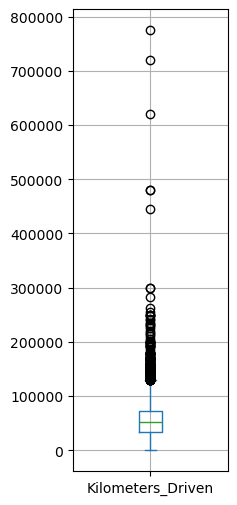

In [89]:
df['Kilometers_Driven'].plot.box(figsize=(2,6))
plt.grid()
plt.show()

Vogliamo sistemare questi outlier imputando il 99° percentile. Perché i valori sono troppo distanti, potrebbe portare solo che rumore al modello. Inoltre nel mercato odierno già sopra un tot chilometri sarebbero da rottamare le auto. Quindi potremmo usare il 99° percentile proprio per dire al modello di considerare l'auto massimamente usata, dato che dopo una certa soglia non c'è quasi nulla più da togliere. 

Soglia (99%): 170000 km


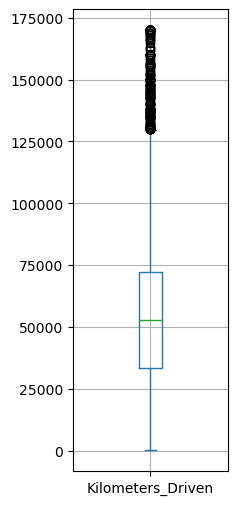

In [90]:
soglia_99 = df['Kilometers_Driven'].quantile(0.99)
print(f"Soglia (99%): {soglia_99:.0f} km")

df['Kilometers_Driven'] = np.where(df['Kilometers_Driven'] > soglia_99, 
                                   soglia_99, 
                                   df['Kilometers_Driven'])

df['Kilometers_Driven'].plot.box(figsize=(2,6))
plt.grid()
plt.show()

In Engine e Power non troviamo valori estremi, o impossibili, ma solo valori molto alti (probabilmente auto di lusso). Quindi corretto lasciare così.

Il boxplot di seats ci indica che probabilmente più del 90% del dataset ha 5 posti. Probabilmente anche per questo motivo viene considerato outlier qualsiasi numero non sia 5. Lasciamo tutto così, dato che è tutto perfettamente plausibile.

Per quanto riguarda Price, abbiamo una distribuzione right-skewed, il che è un problema per il nostro modello di regressione. Conviene fare una trasformazione logaritmica. Guardando il boxplot prima controlliamo se ci sono prezzi troppo bassi. 

In [91]:
# price = df[df['Price'] < 0.5]
# price

In [92]:
# df = df[df['Price'] >= 0.5]
# df.reset_index(drop=True, inplace=True)

In [93]:
# df['Price_Log'] = np.log1p(df['Price'])

Facciamo plotting, per vedere la distribuzione.

In [94]:
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# sns.histplot(df['Price'], kde=True, ax=ax[0])
# ax[0].set_title('Distribuzione Originale (Asimmetrica)')

# sns.histplot(df['Price_Log'], kde=True, ax=ax[1])
# ax[1].set_title('Distribuzione Logaritmica (Simile a Campana)')

# plt.show()

In [95]:
# df.drop('Price', axis=1, inplace=True)
# df.rename(columns={'Price_Log': 'Price'}, inplace=True)


Abbiamo deciso di modificare la nostra variabile Year in Age, per questioni di semplicità, e per rappresentare meglio il deprezzamento o l'obsolescenza dell'auto.

In [96]:
max_year = df['Year'].max()
index_year = df.columns.get_loc('Year')
age_values = max_year - df['Year']
df.insert(index_year, 'Age', age_values)
df.drop('Year', axis=1, inplace=True)
df.head()

,Brand,Model,Location,Age,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti,Wagon,Mumbai,9,72000.0,CNG,Manual,First,26.6000,998,58.16,5,1.75
1,Hyundai,Creta,Pune,4,41000.0,Diesel,Manual,First,16.7195,1582,126.20,5,12.50
2,Honda,Jazz,Chennai,8,46000.0,Petrol,Manual,First,13.4680,1199,88.70,5,4.50
3,Maruti,Ertiga,Chennai,7,87000.0,Diesel,Manual,First,17.6545,1248,88.76,7,6.00
4,Audi,A4,Coimbatore,6,40670.0,Diesel,Automatic,Second,12.9200,1968,140.80,5,17.74


Abbiamo pulito molto bene il dataset, adesso procediamo con la parte successiva. Per quanto comunque, è possibile, che in futuro ci siano nuove problematiche che ci porteranno a modificare passi precendenti, perché, come sappiamo, non è un processo perfettamente lineare.

Modifica di ciccio: salvo il dataframe

In [97]:
df.to_csv('dataframe.csv', index=False)

**Analisi Esplorativa**  
Iniziamo per ordine: Brand. Essendo che ci sono un po' di valori unici ha senso plottare solo i top. 


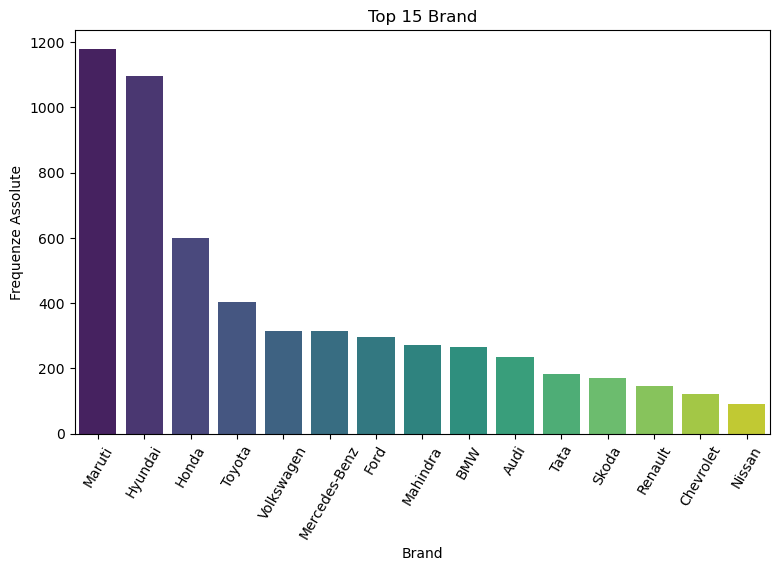

In [98]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)
top_counts = df['Brand'].value_counts().head(15)
    
sns.barplot(x=top_counts.index, y=top_counts.values, hue=top_counts.index, palette='viridis', legend=False)
plt.title('Top 15 Brand')
plt.xticks(rotation=60)
plt.ylabel('Frequenze Assolute')

plt.tight_layout()
plt.show()

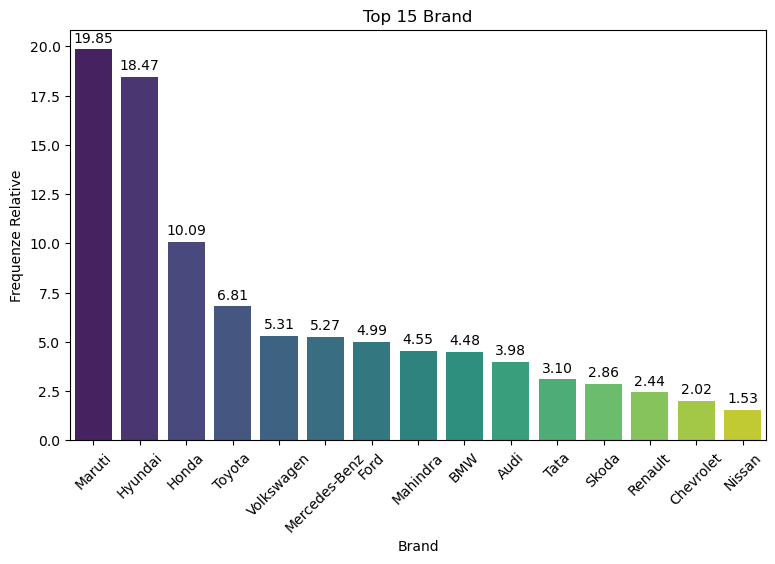

In [99]:
top_relative = df['Brand'].value_counts(normalize=True).head(15) * 100

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)

ax = sns.barplot(x=top_relative.index, y=top_relative.values, hue=top_relative.index, palette='viridis', legend=False)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

plt.title('Top 15 Brand')
plt.xticks(rotation=45)
plt.ylabel('Frequenze Relative')

plt.tight_layout()
plt.show()

Essendoci marchi con pochi elementi potremmo creare due categorie: other_luxury e other. Due perché non vorremo che bentley, lambo ecc... vadano insieme a Smart, per non confondere il modello.

Il rischio per Model, è che ci siano troppi valori unici (207), il che potrebbe portare ad overplotting. Plottiamo solo i top 20:

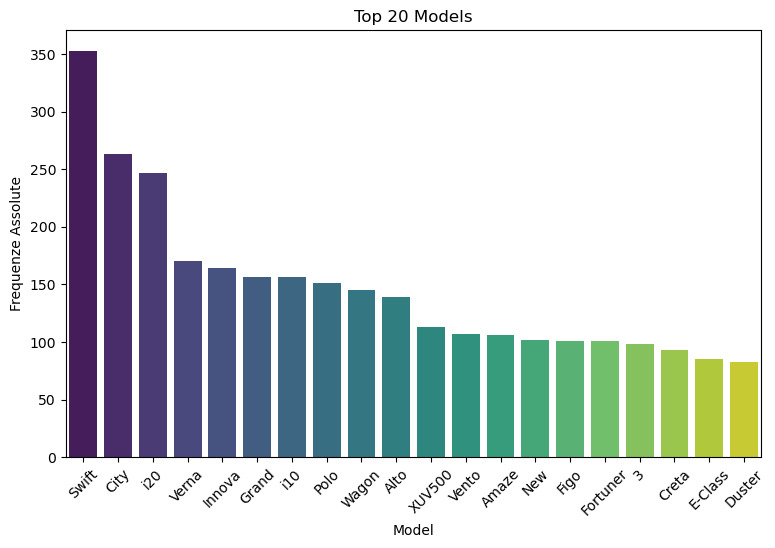

In [100]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)

top_models = df['Model'].value_counts().head(20)

sns.barplot(x=top_models.index, y=top_models.values, palette='viridis', hue=top_models.index)

plt.title('Top 20 Models')
plt.xticks(rotation=45)
plt.ylabel('Frequenze Assolute')

plt.tight_layout()
plt.show()

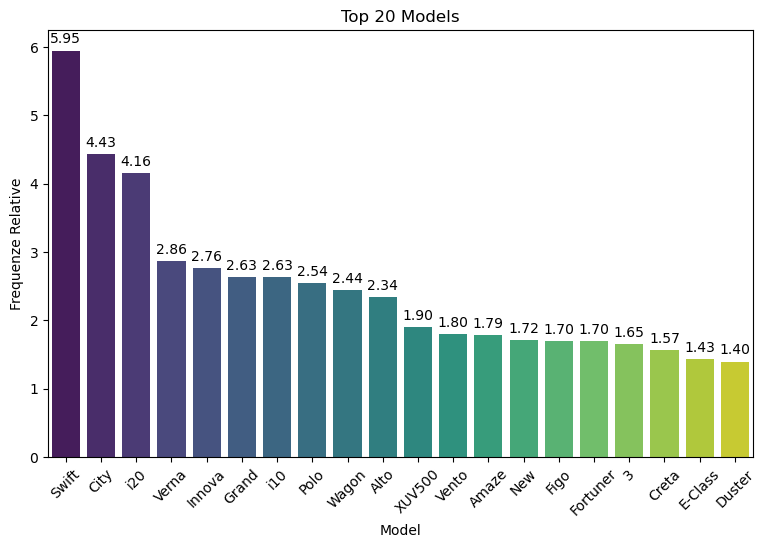

In [101]:
top_relative = df['Model'].value_counts(normalize=True).head(20) * 100

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)

ax = sns.barplot(x=top_relative.index, y=top_relative.values, hue=top_relative.index, palette='viridis', legend=False)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

plt.title('Top 20 Models')
plt.xticks(rotation=45)
plt.ylabel('Frequenze Relative')

plt.tight_layout()
plt.show()

Molto variato. 207 valori unici sono troppi, si potrebbero prendere le categorie a frequenza molto piccola, e unire tutte in "other".

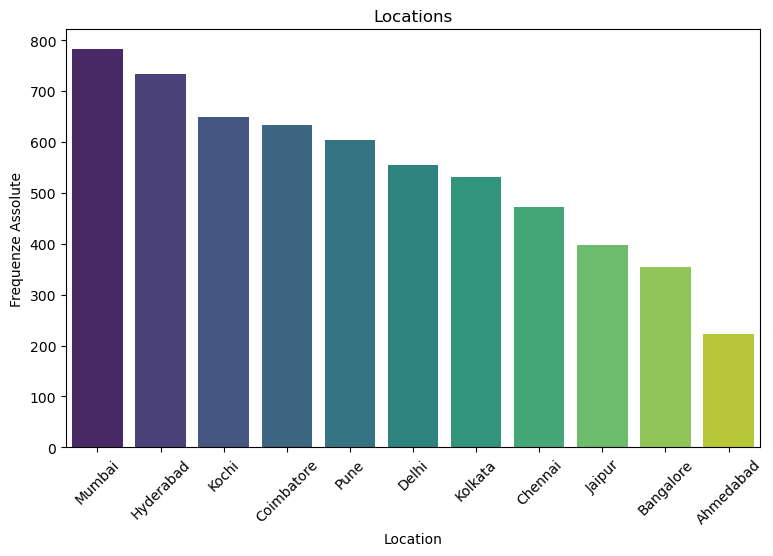

In [102]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)

top_location = df['Location'].value_counts()

sns.barplot(x=top_location.index, y=top_location.values, palette='viridis', hue=top_location.index)

plt.title('Locations')
plt.xticks(rotation=45)
plt.ylabel('Frequenze Assolute')

plt.tight_layout()
plt.show()

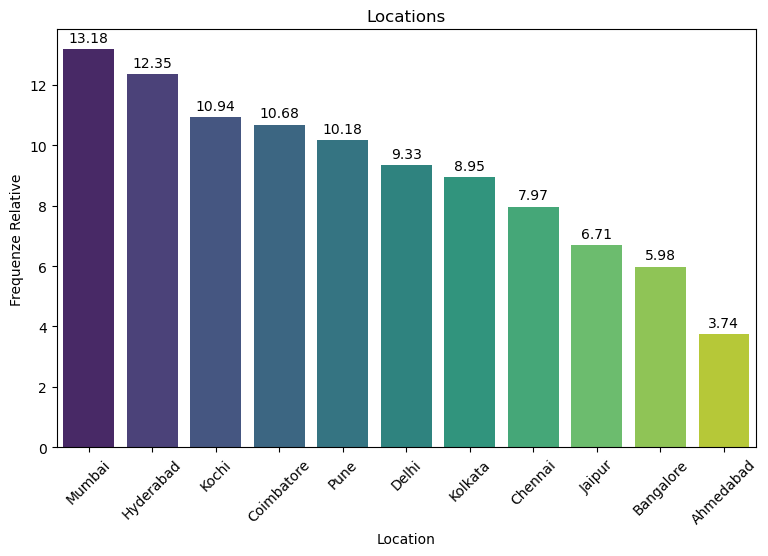

In [103]:
top_relative = df['Location'].value_counts(normalize=True).head(15) * 100

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)

ax = sns.barplot(x=top_relative.index, y=top_relative.values, hue=top_relative.index, palette='viridis', legend=False)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

plt.title('Locations')
plt.xticks(rotation=45)
plt.ylabel('Frequenze Relative')

plt.tight_layout()
plt.show()

Notiamo subito che non c'è nessuna classe dominante, sono tutte più o meno lì. E' messa molto bene come variabile.

Age, essendo numerica ha senso chiedersi le misura di tendenza centrale e quelle di dispersione.

In [104]:
df['Age'].describe()

count    5935.000000
mean        5.493682
std         3.027331
min         0.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        14.000000
Name: Age, dtype: float64

In [105]:
df['Age'].mode()

0    5
Name: Age, dtype: int64

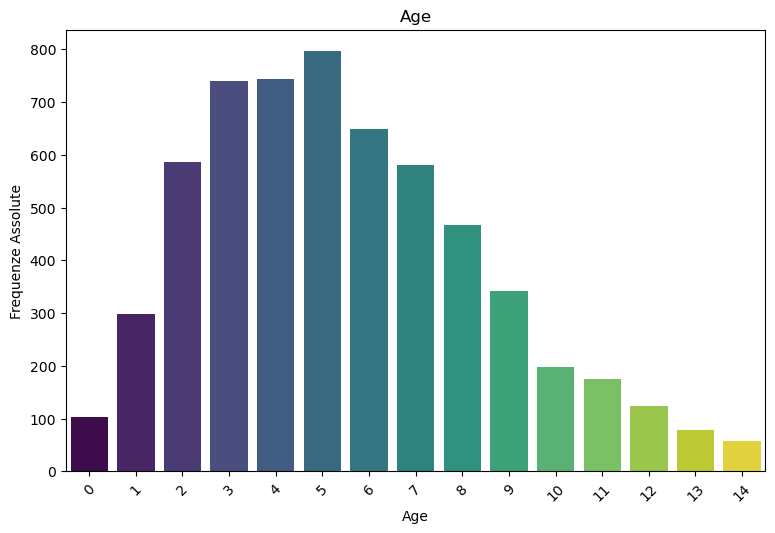

In [106]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)

top_location = df['Age'].value_counts()

sns.barplot(x=top_location.index, y=top_location.values, palette='viridis', hue=top_location.index, legend=False)

plt.title('Age')
plt.xticks(rotation=45)
plt.ylabel('Frequenze Assolute')

plt.tight_layout()
plt.show()

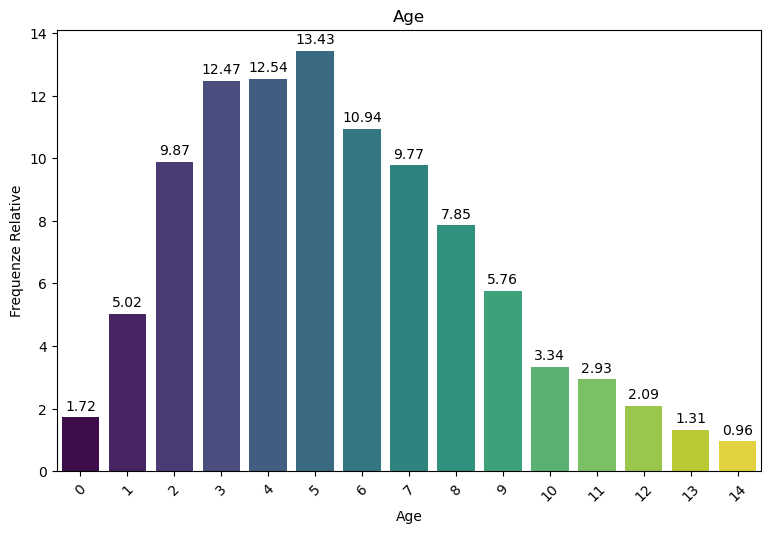

In [107]:
top_relative = df['Age'].value_counts(normalize=True).head(15) * 100

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)

ax = sns.barplot(x=top_relative.index, y=top_relative.values, hue=top_relative.index, palette='viridis', legend=False)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

plt.title('Age')
plt.xticks(rotation=45)
plt.ylabel('Frequenze Relative')

plt.tight_layout()
plt.show()